In [1]:
%pip install pytextrank -q

In [2]:
%pip install datasets transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 72.0 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 17.1 MB/s eta 0:00:00


In [3]:
%pip install pip install git+https://github.com/LIAAD/yake -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 69.0 MB/s eta 0:00:00


In [4]:
from datasets import load_dataset

ds = load_dataset("martingrzzler/mnemonics_benchmark")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/martingrzzler___json/martingrzzler--mnemonics_benchmark-6cc75b71b93e3c15/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("martingrzzler/distilbert-phrase-word-concreteness").to(device)

In [7]:
def predict_concreteness(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding='max_length', max_length=50).to(device)
    inputs.to(device)
    outputs = model(**inputs)
    return outputs.logits.item()

In [8]:
input_words = ds['train'][0]['component_meanings'].split(',') + [ds['train'][0]['kanji_meaning']]
input_words

['woman', 'catapult', 'recreation']

In [11]:
import nltk
stemmer = nltk.stem.PorterStemmer()

def input_in_keyphrase(input_words, keyphrase):
    input_stems = set([stemmer.stem(word) for word in input_words])
    keyphrase_stems = set([stemmer.stem(word) for word in keyphrase.split()])

    return len(input_stems & keyphrase_stems) > 0 


In [41]:
import re
import spacy
import pytextrank


nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("topicrank")

def get_keyphrases(text):
    text = re.sub(r'<.*?>', '', text)
    doc = nlp(text)
    return [phrase.text for phrase in doc._.phrases ]

In [42]:
import numpy as np
def keyphrase_score(text, input_words):
    keyphrases = get_keyphrases(text)
    scores = []
    for keyphrase in keyphrases:
        scores.append(predict_concreteness(keyphrase) * .5 + int(input_in_keyphrase(input_words, keyphrase) * .5))

    return np.average(scores, weights=1/np.arange(1, len(scores) + 1))

In [43]:
sample_index = 14
keys = ['gpt2xl_mnemonic', 'wanikani_mnemonic', 'gpt3_mnemonic', 'gpt3_paragraph']

In [44]:
def get_input_words(sample_index):
    return ds['train'][sample_index]['component_meanings'].split(',') + [ds['train'][sample_index]['kanji_meaning']]

In [45]:
print(get_input_words(sample_index))
for key in keys:
    print(key, keyphrase_score(ds['train'][sample_index][key], get_input_words(sample_index)))

['net', 'say', 'knife', 'penalty']
gpt2xl_mnemonic 0.3701456932417546
wanikani_mnemonic 0.3901765943748409
gpt3_mnemonic 0.3370311691371576
gpt3_paragraph 0.27503321766853334


In [46]:
def keyword_overlap_score(text, input_words):
    keyphrases = get_keyphrases(text)
    scores = []
    for keyphrase in keyphrases:
        scores.append(int(input_in_keyphrase(input_words, keyphrase)))

    return np.average(scores, weights=1/np.arange(1, len(scores) + 1))

In [47]:
def map_keyword_overlap_score(example):
    input_words = example['component_meanings'].split(',') + [example['kanji_meaning']]
    for key in keys:
        example[f'{key}_overlap_score'] = keyword_overlap_score(example[key], input_words)
    return example

In [48]:
ds_overlap = ds['train'].map(map_keyword_overlap_score)

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

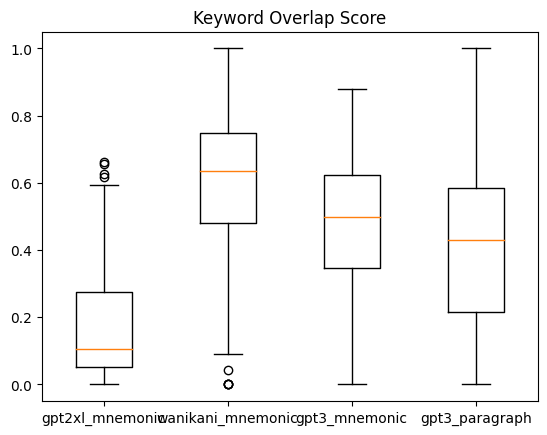

In [49]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_title('Keyword Overlap Score')
ax.boxplot([ds_overlap[f'{key}_overlap_score'] for key in keys])
ax.set_xticklabels(keys)
plt.show()

In [50]:
from scipy.stats import f_oneway

f, p = f_oneway(*[ds_overlap[f'{key}_overlap_score'] for key in keys])
print(f, p)

129.71680141043842 8.701012880187904e-68


In [51]:
from scipy.stats import tukey_hsd

data = [ds_overlap[f'{key}_overlap_score'] for key in keys]

res = tukey_hsd(*[ds_overlap[f'{key}_overlap_score'] for key in keys])
print(res)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.420     0.000    -0.476    -0.363
 (0 - 2)     -0.290     0.000    -0.346    -0.234
 (0 - 3)     -0.246     0.000    -0.302    -0.190
 (1 - 0)      0.420     0.000     0.363     0.476
 (1 - 2)      0.129     0.000     0.073     0.185
 (1 - 3)      0.174     0.000     0.118     0.230
 (2 - 0)      0.290     0.000     0.234     0.346
 (2 - 1)     -0.129     0.000    -0.185    -0.073
 (2 - 3)      0.045     0.173    -0.012     0.101
 (3 - 0)      0.246     0.000     0.190     0.302
 (3 - 1)     -0.174     0.000    -0.230    -0.118
 (3 - 2)     -0.045     0.173    -0.101     0.012



In [52]:
def keyword_concreteness_score(text):
    keyphrases = get_keyphrases(text)
    scores = []
    for keyphrase in keyphrases:
        scores.append(predict_concreteness(keyphrase))

    return np.average(scores, weights=1/np.arange(1, len(scores) + 1))

In [53]:
def map_keyword_concreteness_score(example):
    for key in keys:
        example[f'{key}_concreteness_score'] = keyword_concreteness_score(example[key])
    return example

In [54]:
ds_concreteness = ds['train'].map(map_keyword_concreteness_score)

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [55]:
f, p = f_oneway(*[ds_concreteness[f'{key}_concreteness_score'] for key in keys])

print(f, p)

20.41759020376404 9.918399912027405e-13


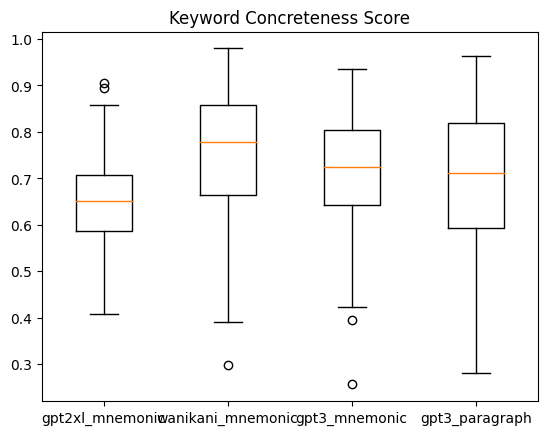

In [56]:
fig, ax = plt.subplots()
ax.set_title('Keyword Concreteness Score')
ax.boxplot([ds_concreteness[f'{key}_concreteness_score'] for key in keys])
ax.set_xticklabels(keys)
plt.show()

In [57]:
res = tukey_hsd(*[ds_concreteness[f'{key}_concreteness_score'] for key in keys])
print(res)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.101     0.000    -0.135    -0.068
 (0 - 2)     -0.062     0.000    -0.096    -0.029
 (0 - 3)     -0.046     0.003    -0.080    -0.012
 (1 - 0)      0.101     0.000     0.068     0.135
 (1 - 2)      0.039     0.016     0.005     0.073
 (1 - 3)      0.056     0.000     0.022     0.090
 (2 - 0)      0.062     0.000     0.029     0.096
 (2 - 1)     -0.039     0.016    -0.073    -0.005
 (2 - 3)      0.017     0.586    -0.017     0.051
 (3 - 0)      0.046     0.003     0.012     0.080
 (3 - 1)     -0.056     0.000    -0.090    -0.022
 (3 - 2)     -0.017     0.586    -0.051     0.017



In [58]:
def map_keyword_score(example):
    input_words = example['component_meanings'].split(',') + [example['kanji_meaning']]
    for key in keys:
        example[f'{key}_score'] = keyphrase_score(example[key], input_words)
    return example

In [59]:
ds_combined = ds['train'].map(map_keyword_score)

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [61]:
f, p = f_oneway(*[ds_combined[f'{key}_score'] for key in keys])

print(f, p)

20.41759020376404 9.918399912027405e-13


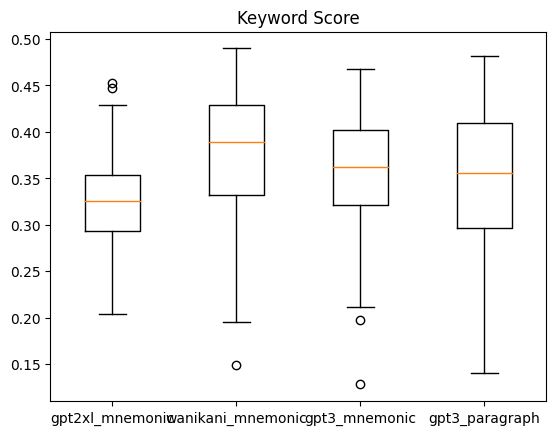

In [62]:
fig, ax = plt.subplots()
ax.set_title('Keyword Score')
ax.boxplot([ds_combined[f'{key}_score'] for key in keys])
ax.set_xticklabels(keys)
plt.show()

In [63]:
ser_model = DistilBertForSequenceClassification.from_pretrained("martingrzzler/distilbert-sensory-modality").to(device)

In [64]:
def predict_sensory_modality(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding='max_length', max_length=10).to(device)
    inputs.to(device)
    outputs = ser_model(**inputs)
    return outputs.logits.item()

In [79]:
# this model was trained on single words
def keyphrase_sensory_modality_score(text):
    keyphrases = get_keyphrases(text)
    scores = []
    for keyphrase in keyphrases:
        keywords = keyphrase.split(' ')
        word_scores = [predict_sensory_modality(word.lower()) for word in keywords]

        scores.append(np.mean(word_scores))

    return np.average(scores, weights=1/np.arange(1, len(scores) + 1))

In [73]:
def map_keyword_sensory_modality_score(example):
    for key in keys:
        example[f'{key}_sensory_modality_score'] = keyphrase_sensory_modality_score(example[key])
    return example

In [80]:
map_keyword_sensory_modality_score(ds['train'][0])

{'kanji_id': 1885,
 'component_meanings': 'woman,catapult',
 'wanikani_mnemonic': "A <radical>woman</radical> loves her <radical>catapult</radical> for some good ol' fashioned <kanji>recreation</kanji>. You ask the woman what she does for fun... for recreation. She says, she goes out and shoots her catapult.",
 'kanji_meaning': 'recreation',
 'gpt2xl_mnemonic': "This is a rush transcript. Copy may not be in its final form, recreation of woman being catapulted to her death has been edited out.)\n\n\nAMY GOODMAN: We begin today's show with the shocking news that two women have died after jumping from an overpass near Los Angeles International Airport and landing on I-5 southbound just before",
 'gpt3_paragraph': 'A woman was using a catapult for recreation in her backyard. She was having a blast launching objects into the air and watching them fly. She was enjoying the peacefulness of the moment and the satisfaction of her successful shots.',
 'gpt3_mnemonic': "Once upon a time there was

In [81]:
ds_ser = ds['train'].map(map_keyword_sensory_modality_score)

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [82]:
f, p = f_oneway(*[ds_ser[f'{key}_sensory_modality_score'] for key in keys])

print(f, p)

8.70431005848819 1.1079841875245505e-05


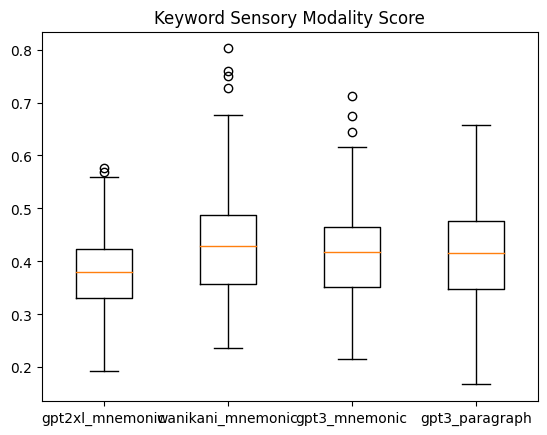

In [83]:
fig, ax = plt.subplots()
ax.set_title('Keyword Sensory Modality Score')
ax.boxplot([ds_ser[f'{key}_sensory_modality_score'] for key in keys])
ax.set_xticklabels(keys)
plt.show()

In [84]:
img_model = DistilBertForSequenceClassification.from_pretrained("martingrzzler/distilbert-imageability").to(device)

In [85]:
def predict_imageability(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding='max_length', max_length=10).to(device)
    inputs.to(device)
    outputs = img_model(**inputs)
    return outputs.logits.item()

In [90]:
def keyword_imageability_score(text):
    keyphrases = get_keyphrases(text)
    scores = []
    for keyphrase in keyphrases:
        keywords = keyphrase.split(' ')
        word_scores = [predict_imageability(word.lower()) for word in keywords]

        scores.append(np.mean(word_scores))

    return np.average(scores, weights=1/np.arange(1, len(scores) + 1))

In [91]:
def map_keyword_imageability_score(example):
    for key in keys:
        example[f'{key}_imageability_score'] = keyword_imageability_score(example[key])
    return example

In [92]:
map_keyword_imageability_score(ds['train'][0])

{'kanji_id': 1885,
 'component_meanings': 'woman,catapult',
 'wanikani_mnemonic': "A <radical>woman</radical> loves her <radical>catapult</radical> for some good ol' fashioned <kanji>recreation</kanji>. You ask the woman what she does for fun... for recreation. She says, she goes out and shoots her catapult.",
 'kanji_meaning': 'recreation',
 'gpt2xl_mnemonic': "This is a rush transcript. Copy may not be in its final form, recreation of woman being catapulted to her death has been edited out.)\n\n\nAMY GOODMAN: We begin today's show with the shocking news that two women have died after jumping from an overpass near Los Angeles International Airport and landing on I-5 southbound just before",
 'gpt3_paragraph': 'A woman was using a catapult for recreation in her backyard. She was having a blast launching objects into the air and watching them fly. She was enjoying the peacefulness of the moment and the satisfaction of her successful shots.',
 'gpt3_mnemonic': "Once upon a time there was

In [93]:
ds_img = ds['train'].map(map_keyword_imageability_score)

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [94]:
f, p = f_oneway(*[ds_img[f'{key}_imageability_score'] for key in keys])

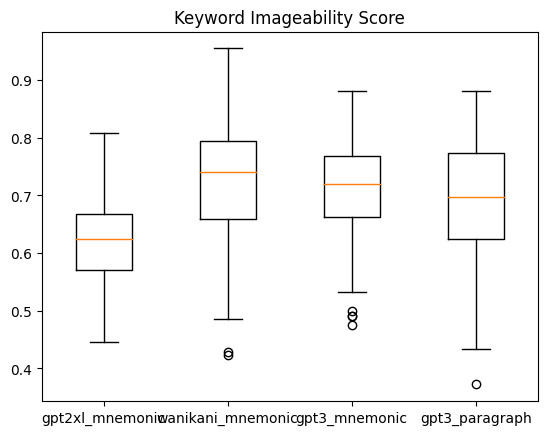

In [95]:
fig, ax = plt.subplots()
ax.set_title('Keyword Imageability Score')
ax.boxplot([ds_img[f'{key}_imageability_score'] for key in keys])
ax.set_xticklabels(keys)
plt.show()

In [137]:
print(tukey_hsd(*[ds_img[f'{key}_imageability_score'] for key in keys]))

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.104     0.000    -0.128    -0.081
 (0 - 2)     -0.091     0.000    -0.115    -0.067
 (0 - 3)     -0.071     0.000    -0.095    -0.047
 (1 - 0)      0.104     0.000     0.081     0.128
 (1 - 2)      0.014     0.457    -0.010     0.037
 (1 - 3)      0.033     0.002     0.010     0.057
 (2 - 0)      0.091     0.000     0.067     0.115
 (2 - 1)     -0.014     0.457    -0.037     0.010
 (2 - 3)      0.020     0.135    -0.004     0.044
 (3 - 0)      0.071     0.000     0.047     0.095
 (3 - 1)     -0.033     0.002    -0.057    -0.010
 (3 - 2)     -0.020     0.135    -0.044     0.004



In [97]:
import numpy as np
def keyphrase_metric(text, input_words):
    keyphrases = get_keyphrases(text)
    scores = []
    for keyphrase in keyphrases:
        scores.append(predict_concreteness(keyphrase) * .5 + \
                       int(input_in_keyphrase(input_words, keyphrase) * .5/3) + \
                       np.mean([predict_sensory_modality(word.lower()) for word in keyphrase.split(' ')]) * .5/3 + \
                          np.mean([predict_imageability(word.lower()) for word in keyphrase.split(' ')]) * .5/3
                      )

    return np.average(scores, weights=1/np.arange(1, len(scores) + 1))

In [98]:
def map_keyword_metric(example):
    input_words = example['component_meanings'].split(',') + [example['kanji_meaning']]
    for key in keys:
        example[f'{key}_metric'] = keyphrase_metric(example[key], input_words)
    return example

In [100]:
ds_metric = ds['train'].map(map_keyword_metric)

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [101]:
f, p = f_oneway(*[ds_metric[f'{key}_metric'] for key in keys])

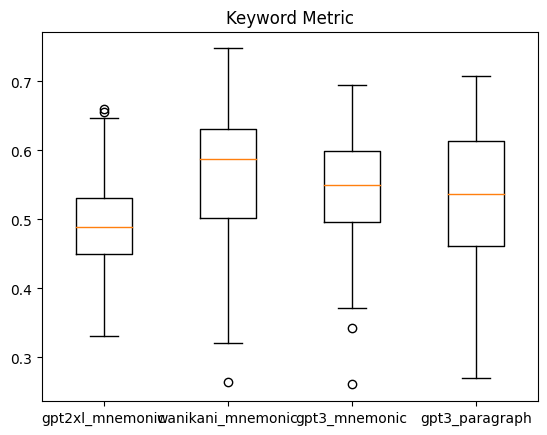

In [102]:
fig, ax = plt.subplots()
ax.set_title('Keyword Metric')
ax.boxplot([ds_metric[f'{key}_metric'] for key in keys])
ax.set_xticklabels(keys)
plt.show()

In [136]:
print(tukey_hsd(*[ds_metric[f'{key}_metric'] for key in keys]))

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.076     0.000    -0.098    -0.054
 (0 - 2)     -0.052     0.000    -0.074    -0.029
 (0 - 3)     -0.039     0.000    -0.062    -0.017
 (1 - 0)      0.076     0.000     0.054     0.098
 (1 - 2)      0.024     0.026     0.002     0.047
 (1 - 3)      0.036     0.000     0.014     0.059
 (2 - 0)      0.052     0.000     0.029     0.074
 (2 - 1)     -0.024     0.026    -0.047    -0.002
 (2 - 3)      0.012     0.505    -0.010     0.034
 (3 - 0)      0.039     0.000     0.017     0.062
 (3 - 1)     -0.036     0.000    -0.059    -0.014
 (3 - 2)     -0.012     0.505    -0.034     0.010



In [129]:
ds_metric.to_pandas().sort_values('wanikani_mnemonic_metric', ascending=False)['wanikani_mnemonic'][:3].apply(print)

You take a <radical>turkey</radical> and try to <radical>boil</radical> it but you <kanji>char</kanji> it instead. That's what happens when you throw meat into a pot on high with no water in there. You should know better than to try to boil something without water! Now what are you going to do with this raw, but charred turkey?!
<radical>Flowers</radical> that you <radical>oversee</radical> are always <kanji>indigo</kanji>. You aren't sure why though... Imagine if every flower you were supposed to oversee was indigo. Indigo everywhere!
A <radical>tsunami</radical> lifts all the <radical>trash</radical> out of the <radical>river</radical> and it <kanji>stream</kanji>s out onto the shores. As the tsunami recedes, watch as all of the trash comes streaming out of the river and crowds the bank.


46     None
187    None
105    None
Name: wanikani_mnemonic, dtype: object

In [131]:
ds_metric.to_pandas().sort_values('gpt3_paragraph_metric')[:3].apply(lambda x : print(x['kanji_meaning'], x['component_meanings']), axis=1)
ds_metric.to_pandas().sort_values('gpt3_paragraph_metric')['gpt3_paragraph'][:3].apply(print)

recollection soul,idea
limit building,root
kindness mouth,big,heart
The soul is a mysterious thing, and it can often hold onto ideas and recollections that one would have thought long forgotten. It is a powerful thing, and it can bring back memories and feelings that have been long buried, and can open up new possibilities and ideas.
Building a strong foundation is essential for any successful endeavor, and the root of that foundation is to set limits. Having predetermined limits allows for better organization, planning, and goal setting.
My big mouth has gotten me into trouble in the past, but I have a big heart to match it. I believe in the power of kindness and strive to treat others with respect and understanding.


86     None
56     None
138    None
Name: gpt3_paragraph, dtype: object

In [134]:
keyphrase_metric(ds['train']['gpt3_paragraph'][86], ['recollection', 'soul', 'idea'])

0.27065905375120514

In [138]:
t = 'In a bustling city, a towering skyscraper was intertwined with an ancient tree\'s roots. The roots provided strength and support, but they had a limit. A wise old man warned that if the building grew too tall, the roots would give way and the skyscraper would crumble. This vivid image serves as a reminder: even the mightiest roots have a limit to their support.'
keyphrase_metric(t, ['limit', 'building', 'root'])

0.39502933464887785

These findings are promising but perhaps keywords aren't the best approach or insufficient. 
It may make sense to quantify the connection of the input words somehow. If the words are represented as a graph,
it may be very useful to extract the edges between the input words.

In [139]:
get_keyphrases(t)

['ancient trees roots',
 'support',
 'limit',
 'towering skyscraper',
 'strength',
 'way',
 'wise old man',
 'vivid image',
 'reminder',
 'building',
 'bustling city']